##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantization Aware Training : CIFAR-10

Ce notebook est un dérivé du notebook tutoriel créé directement par Tensor Flow. 
La source est disponible ci-dessous :

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/model_optimization/guide/quantization/training_example"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/quantization/training_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/model-optimization/blob/master/tensorflow_model_optimization/g3doc/guide/quantization/training_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/model-optimization/tensorflow_model_optimization/g3doc/guide/quantization/training_example.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Synthèse

La _Qautnization Aware Training (QAT)_ émule la quantification au moment de l'inférence, créant un modèle que les outils en aval utiliseront pour produire des modèles réellement quantifiés. Les modèles quantifiés utilisent une précision plus faible (par exemple, 8 bits au lieu de 32 bits flottants), ce qui présente des avantages lors du déploiement.

La quantification apporte des améliorations grâce à la compression du modèle et à la réduction de la latence. Avec les valeurs par défaut de l'API, la taille du modèle est réduite par 4, et nous constatons généralement une latence CPU 1,5 à 4 fois inférieure. Enfin, des améliorations de la latence peuvent être observées sur les accélérateurs compatibles, tels que [EdgeTPU](https://coral.ai/docs/edgetpu/benchmarks/) et NNAPI.

La technique est utilisée en production dans les domaines de la parole, de la vision, du texte et de la traduction. Le code prend actuellement en charge un [sous-ensemble de ces modèles](https://www.tensorflow.org/model_optimization/guide/quantization/training#general_support_matrix).

Les utilisateurs peuvent configurer les paramètres de quantification (par exemple, le nombre de bits) et, dans une certaine mesure, les algorithmes sous-jacents. Notez qu'avec ces changements par rapport aux valeurs par défaut de l'API, il n'y a actuellement aucun chemin supporté pour le déploiement vers un backend. Par exemple, la conversion TFLite et les implémentations du noyau ne prennent en charge que la quantification sur 8 bits.

Les API spécifiques à cette configuration sont expérimentales et ne font pas l'objet d'une rétrocompatibilité.

Pour en savoir plus sur les différentes stratégies de quantification, lisez [TensorFlow Lite model optimization](https://www.tensorflow.org/lite/performance/model_optimization).

## Objectif

L'objectif de ce hands-on est de créer un modèle, de l'entrainer, de le quantifier, de comparer les performances entre le modèle classique et quantifié et de comparer leurs émissions CO2eq pour l'inférence. Nous allons ici utiliser plusieurs stratégies de quantification pendant l'entrainement : "à chaud" et "à froid".

Le déroulement se fait donc en 3 grandes étapes :
1. Contruction d'un modèle pour CIFAR-10
2. Quantification du modèle selon 2 stratégies différentes
3. Comparaison des modèles TFLite

## Dataset

Le dataset utilisé pour ce notebook est le célèbre CIFAR (Canadian Institute For Advanced Research), composé d'images de 10 classes (d'où le CIFAR-10, il existe aussi le CIFAR-100 pour plus de classes). Les catégories d'images sont :
- avions
- voitures
- oiseaux
- chats
- cerfs
- chiens
- grenouilles
- chevaux
- bateaux
- camions

Le dataset contient 50000 images d'entrainement et 10000 de test, donc au total 6000 images par classe. Les images sont de taille 32x32.

[Wikipédia CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10)

<img src="https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png">

## Construction d'un modèle pour CIFAR-10

### Préparation

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
from keras import layers
from keras import models
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras import optimizers
from keras.layers import Resizing
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D, BatchNormalization,LayerNormalization

### Entrainement du modèle Tensor Flow

<a id='simple_cifar_model'></a>

Tout d'abord, on commence par créer une fonction _mobile_net_for_cifar10_ pour définir notre modèle séquentiel.

En plus de la quantification, nous allons utiliser du Transfer Learning pour faire converger notre modèle plus rapidement. Le dataset ImageNet est constitué d'images de 1000 classes diverses et variées et dont certaines sont (ou se rapprochent) de nos classes objectifs avec CIFAR-10. Il est donc pertinent de partir d'un modèle pré-entrainé sur ces données.

Le modèle est composé d'un modèle MobileNet pré-entrainé sur les données ImageNet auquel on a remplacé la couche de MLP finale par une nouvelle couche de MLP personnalisée. En amont de ce modèle, nous devons placer une couche de redimensionnement des images car les modèles pré-entrainés sur ImageNet peuvent prendre en entrer des images carrés soit en 128, 160, 192 ou 224 pixels de côté. 

Nous prenons le modèle en 224 pixels car c'est celui avec la meilleure précision avec 70,6%. Les précisions en fonction des différentes tailles sont disponibles dans la [documentation tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet).

In [2]:
INPUT_IMG_SIZE = 224

def mobile_net_for_cifar10():
    # Base model for the mobilenet model
    mobnet_model = MobileNet(weights='imagenet',include_top=False,
                            input_shape=(INPUT_IMG_SIZE,INPUT_IMG_SIZE,3)) 
    #imports the mobilenet model and discards the last 1000 neuron layer.
    
    image_size = (INPUT_IMG_SIZE,INPUT_IMG_SIZE)
    
    img_inputs = keras.Input(shape=(32, 32, 3))
    x = keras.layers.Resizing(image_size[0], image_size[1], interpolation="bilinear")(img_inputs)

    # Base model for the mobilenet model
    #imports the mobilenet model and discards the last 1000 neuron layer.
    mobnet_model = MobileNet(weights='imagenet',include_top=False, 
                             input_shape=(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3),
                             input_tensor=x)
    
    x = GlobalAveragePooling2D()(mobnet_model.output)
    outputs = Dense(10,activation=('softmax'))(x)

    model = tf.keras.Model(img_inputs, outputs)

    # Creating the model and compiling it
    model.compile(loss='sparse_categorical_crossentropy',
                optimizer= 'Adam',
                metrics=['accuracy'])
    
    return model

Il nous faut après charger les données du dataset CIFAR-10, directement avec Keras.

<div class="alert alert-block alert-info"><b>Note:</b> Plusieurs datasets sont directements accessibles avec le module <a href="https://www.tensorflow.org/api_docs/python/tf/keras/datasets">keras.datasets</a> (documentation Tensor Flow). <br>
&emsp;&emsp;&emsp; La liste est aussi disponible sur la <a href="https://keras.io/api/datasets/">documentation de l'API Keras.</a></div>

In [3]:
# Load CIFAR-10 dataset
cifar10 = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

Nous séparons ensuite le dataset d'entrainement pour avoir un ensemble de validation en plus, et nous limitons à 10000 le nombre d'exemples de tests pour que les comparaisons (plus tard) se fassent dans un temps raisonnable.

In [4]:
x_test, y_test = test_images[:10000], test_labels[:10000]
x_train, y_train = train_images, train_labels

Enfin, il nous reste à définir le modèle avec la [fonction créée ci-dessus](#simple_cifar_model).

Nous pouvons ainsi avoir un résumé de notre modèle par couche (bien que le MobileNet soit condensé en une couche alors qu'en réalité il s'agit de nombreuses couches), ainsi que le nombre de paramètres fixes ou à entraîner. Nous aurions également pu, si nous le souhaitions, figer le MobileNet pour n'entrainer que le MLP final (c'est une stratégie différente de Transfer Learning) alors qu'ici nous continuons à en entrainer ses poids.

In [10]:
# Define the model architecture
model = mobile_net_for_cifar10()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                           

                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9

Si vous avez déjà entrainé un modèle avec cette architecture, vous pouvez en charger les poids ici et directement passer à la [__quantification du modèle__](#quantify_model).

In [ ]:
#model.load_weights("cifar10_mobilenet_qat_float_903.h5")
#model.evaluate(x_test, y_test)

Nous allons également définir un _callback_ EarlyStopping pour arrêter l'entrainement en cas de surapprentissage.

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
                                     restore_best_weights=True)

Il nous reste à l'entrainer. Nous commençons par 3 epochs.

In [12]:
history = model.fit(x_train, y_train, batch_size=32, steps_per_epoch=100, 
                    epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
100/100 [==============================] - 32s 304ms/step - loss: 1.0950 - accuracy: 0.6488 - val_loss: 3.7928 - val_accuracy: 0.3335
Epoch 2/50
100/100 [==============================] - 29s 295ms/step - loss: 0.7569 - accuracy: 0.7563 - val_loss: 2.4180 - val_accuracy: 0.5425
Epoch 3/50
100/100 [==============================] - 29s 296ms/step - loss: 0.6089 - accuracy: 0.7956 - val_loss: 1.2274 - val_accuracy: 0.6837
Epoch 4/50
100/100 [==============================] - 30s 297ms/step - loss: 0.6023 - accuracy: 0.7994 - val_loss: 0.8569 - val_accuracy: 0.7454
Epoch 5/50
100/100 [==============================] - 30s 298ms/step - loss: 0.5420 - accuracy: 0.8178 - val_loss: 1.0667 - val_accuracy: 0.6956
Epoch 6/50
100/100 [==============================] - 30s 300ms/step - loss: 0.4825 - accuracy: 0.8347 - val_loss: 0.8493 - val_accuracy: 0.7350
Epoch 7/50
100/100 [==============================] - 29s 296ms/step - loss: 0.4487 - accuracy: 0.8453 - val_loss: 0.6372 - val_ac

Pour cet exemple, comme nous n'avons entraîné le modèle que sur 3 épochs, il atteint une précision en entraînement de ~91 % et ~86 % en validation, ce qui est tout à fait correct.

Nous pouvons visualier l'évolution de la _loss_ d'entrainenment (Training) et de validation (Validation) sur ce graph.

In [13]:
def plot_history(history):
    plt.plot(history.epoch, history.history["loss"], 'b', label='Training')
    plt.plot(history.epoch, history.history["val_loss"], 'g', label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

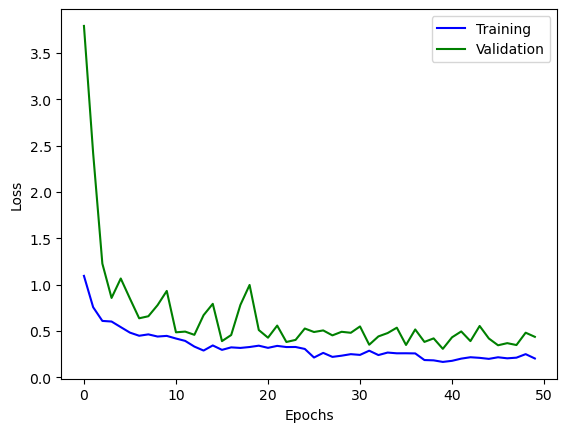

In [14]:
plot_history(history)

On voit ainsi que nous étions en "descente" pure des courbes de _loss_. Nous aurions donc sans doute pû entrainer le modèle pour plus d'epochs sans qu'il sur-entraîne.

Nous allons sauvegarder les poids de ce modèle "float" pour les réutiliser dans d'autres notebooks de comparaisons de modèles.

In [15]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 16s 52ms/step - loss: 0.3244 - accuracy: 0.8944


[0.32443809509277344, 0.8944000005722046]

In [16]:
model.save_weights("cifar10_mobilenet_qat_float_894.h5")

<a id='quantify_model'></a>

## Quantification du modèle selon 2 stratégies différentes

Tout d'abord, il faut install la librairie d'optimisations des modèles de Tensor Flow. En effet, pour le QAT les fonctions ne sont pas incluses dans la librairie principale Tensor Flow.

In [17]:
!pip install tensorflow_model_optimization

In [18]:
import tensorflow_model_optimization as tfmot

Nous devons dans notre cas définir une fonction pour que toutes les couches soient quantifiées, mis à part la couche de _Resizing_ de l'image car elle n'a pas de poids et à cause de cela n'est pas supportée pour la transformation en couche d'apprentissage quantifiée pour la librairie.

In [104]:
# Helper function uses `quantize_annotate_layer` to annotate that only the 
# Resizing layer should not be quantized (there are no weights or whatever).
def apply_quantization_except_resizing(layer):
    if isinstance(layer, tf.keras.layers.Resizing):
        return layer
    return tfmot.quantization.keras.quantize_annotate_layer(layer)

Cette fonction dépendra donc du modèle sur lequel on travaille. Si toutes les couches sont supportées on peut directement utiliser la fonction [_quantize_model_](https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/quantization/keras/quantize_model) au lieu de cloner le modèle puis d'appliquer _quantize_apply_.

### Fine-tuning avec QAT - "Warm Start"

Nous allons __cloner le modèle de base que nous avons déjà entrainé__ en utilisant la fonction que nous venons de créer, puis nous allons quantifier le type des couches avec _quantize_apply_. Enfin on peut compiler le modèle et afficher le résumé du modèle.

L'idée ici est de partir du modèle _float_ entrainé précédemment et "finir" son entrainement en ajustant les poids pour espérer avoir une quantification avec moins de perte.

In [26]:
# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
q_aware_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_except_resizing,
)

# q_aware stands for for quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_apply(q_aware_model)


# `quantize_model` requires a recompile.
q_aware_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer= 'Adam',
                      metrics=['accuracy'])

q_aware_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 quant_conv1 (QuantizeWrappe  (None, 112, 112, 32)     929       
 rV2)                                                            
                                                                 
 quant_conv1_bn (QuantizeWra  (None, 112, 112, 32)     129       
 pperV2)                                                         
                                                                 
 quant_conv1_relu (QuantizeW  (None, 112, 112, 32)     3         
 rapperV2)                                                       
                                                           

 quant_conv_pw_6 (QuantizeWr  (None, 14, 14, 512)      132097    
 apperV2)                                                        
                                                                 
 quant_conv_pw_6_bn (Quantiz  (None, 14, 14, 512)      2049      
 eWrapperV2)                                                     
                                                                 
 quant_conv_pw_6_relu (Quant  (None, 14, 14, 512)      3         
 izeWrapperV2)                                                   
                                                                 
 quant_conv_dw_7 (QuantizeWr  (None, 14, 14, 512)      4611      
 apperV2)                                                        
                                                                 
 quant_conv_dw_7_bn (Quantiz  (None, 14, 14, 512)      2049      
 eWrapperV2)                                                     
                                                                 
 quant_con

                                                                 
 quant_conv_dw_13_relu (Quan  (None, 7, 7, 1024)       3         
 tizeWrapperV2)                                                  
                                                                 
 quant_conv_pw_13 (QuantizeW  (None, 7, 7, 1024)       1050625   
 rapperV2)                                                       
                                                                 
 quant_conv_pw_13_bn (Quanti  (None, 7, 7, 1024)       4097      
 zeWrapperV2)                                                    
                                                                 
 quant_conv_pw_13_relu (Quan  (None, 7, 7, 1024)       3         
 tizeWrapperV2)                                                  
                                                                 
 quant_global_average_poolin  (None, 1024)             3         
 g2d_1 (QuantizeWrapperV2)                                       
          

On voit ainsi que le type des couches a changé, mais le nombre de paramètres (à apprendre ou non) n'a lui pas changé.

Nous pouvons ainsi passer à l'entrainement pour "fine tune" l'apprentissage sur ce modèle sensible à la quantification. Nous pouvons entrainer soit sur le dataset d'entrainement complet ou bien sur une sous-partie du dataset. Ici, on utilisera le dataset complet.

In [ ]:
# Maybe try on a subset for REAL fine tune and not just training ?
train_images_subset = train_images[0:1000] # out of 60000
train_labels_subset = train_labels[0:1000]

Continuons donc d'entrainer le modèle avec les mêmes paramètres, cette fois avec des couches sensibles à la quantification.

Il faut noter que, dû aux étapes supplémentaires de quantification et de mesure de la perte en quantifié, l'apprentissage est bien plus lent (environ 3 fois plus lent).

In [40]:
history_quant = q_aware_model.fit(x_train, y_train, batch_size=32, steps_per_epoch=100, 
                    epochs=50, validation_split=0.2, callbacks=[es])

Epoch 1/50
100/100 [==============================] - 127s 1s/step - loss: 0.2311 - accuracy: 0.9228 - val_loss: 0.5528 - val_accuracy: 0.8405
Epoch 2/50
100/100 [==============================] - 125s 1s/step - loss: 0.2190 - accuracy: 0.9175 - val_loss: 0.4361 - val_accuracy: 0.8593
Epoch 3/50
100/100 [==============================] - 127s 1s/step - loss: 0.2224 - accuracy: 0.9234 - val_loss: 0.5826 - val_accuracy: 0.8228
Epoch 4/50
100/100 [==============================] - 124s 1s/step - loss: 0.2298 - accuracy: 0.9209 - val_loss: 0.4960 - val_accuracy: 0.8505
Epoch 5/50
100/100 [==============================] - 124s 1s/step - loss: 0.1963 - accuracy: 0.9316 - val_loss: 0.4469 - val_accuracy: 0.8664
Epoch 6/50
100/100 [==============================] - 129s 1s/step - loss: 0.2402 - accuracy: 0.9159 - val_loss: 0.4130 - val_accuracy: 0.8649
Epoch 7/50
100/100 [==============================] - 129s 1s/step - loss: 0.1921 - accuracy: 0.9362 - val_loss: 0.4734 - val_accuracy: 0.8541

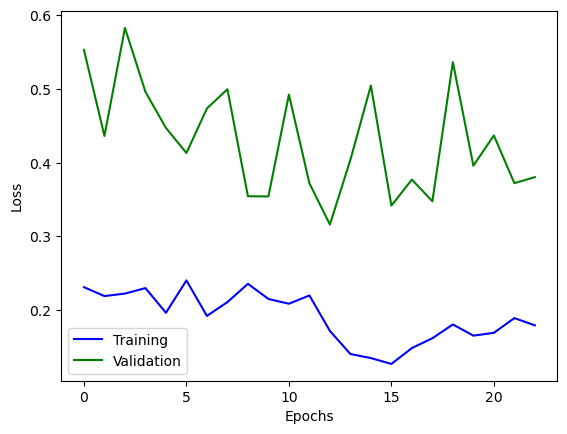

In [41]:
plot_history(history_quant)

In [42]:
q_aware_model.evaluate(x_test, y_test)

313/313 [==============================] - 67s 215ms/step - loss: 0.3269 - accuracy: 0.8942


[0.32688313722610474, 0.8942000269889832]

Nous obtenons alors une précision sur le dataset de test proche de celle obtenue avec le premier entrainement en _full float_. La différence à espérer devrait être principalement visible entre pour une quantification en int8, entre un modèle avec QAT ou uniquement conversion PTQ.

In [43]:
q_aware_model.save_weights("cifar10_mobilenet_qat_warm_894.h5")

### Entrainement complet en QAT - "Cold Start"

Nous allons __prendre un modèle vierge__ et le préparer à l'entrainement sensible à la quantification avec _quantize_apply_, où on exclue encore la couche de _Resizing_. Enfin on peut compiler le modèle et afficher le résumé du modèle.

L'idée ici est de partir de zéro, directement avec un QAT pour espérer ainsi obtenir la quantification en int8 avec le moins de perte possible. Encore une fois, comme nous l'avons précisé précédemment, dû aux étapes supplémentaires de quantification et de mesure de la perte en quantifié, l'apprentissage est bien plus lent (environ 3 fois plus lent).

In [28]:
q_aware_model_v2 = mobile_net_for_cifar10()

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
q_aware_model_v2 = tf.keras.models.clone_model(
    q_aware_model_v2,
    clone_function=apply_quantization_except_resizing,
)

# q_aware stands for for quantization aware.
q_aware_model_v2 = tfmot.quantization.keras.quantize_apply(q_aware_model_v2)

# `quantize_model` requires a recompile.
q_aware_model_v2.compile(loss='sparse_categorical_crossentropy',
                         optimizer= 'Adam',
                         metrics=['accuracy'])

q_aware_model_v2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resizing_3 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 quant_conv1 (QuantizeWrappe  (None, 112, 112, 32)     929       
 rV2)                                                            
                                                                 
 quant_conv1_bn (QuantizeWra  (None, 112, 112, 32)     129       
 pperV2)                                                         
                                                                 
 quant_conv1_relu (QuantizeW  (None, 112, 112, 32)     3         
 rapperV2)                                                       
                                                           

 quant_conv_pw_6 (QuantizeWr  (None, 14, 14, 512)      132097    
 apperV2)                                                        
                                                                 
 quant_conv_pw_6_bn (Quantiz  (None, 14, 14, 512)      2049      
 eWrapperV2)                                                     
                                                                 
 quant_conv_pw_6_relu (Quant  (None, 14, 14, 512)      3         
 izeWrapperV2)                                                   
                                                                 
 quant_conv_dw_7 (QuantizeWr  (None, 14, 14, 512)      4611      
 apperV2)                                                        
                                                                 
 quant_conv_dw_7_bn (Quantiz  (None, 14, 14, 512)      2049      
 eWrapperV2)                                                     
                                                                 
 quant_con

                                                                 
 quant_conv_dw_13_relu (Quan  (None, 7, 7, 1024)       3         
 tizeWrapperV2)                                                  
                                                                 
 quant_conv_pw_13 (QuantizeW  (None, 7, 7, 1024)       1050625   
 rapperV2)                                                       
                                                                 
 quant_conv_pw_13_bn (Quanti  (None, 7, 7, 1024)       4097      
 zeWrapperV2)                                                    
                                                                 
 quant_conv_pw_13_relu (Quan  (None, 7, 7, 1024)       3         
 tizeWrapperV2)                                                  
                                                                 
 quant_global_average_poolin  (None, 1024)             3         
 g2d_3 (QuantizeWrapperV2)                                       
          

On voit ainsi que, comme avant, le type des couches a changé, mais le nombre de paramètres (à apprendre ou non) n'a lui pas changé.

Nous pouvons ainsi passer à l'entrainement. Nous allons simplement changer l'_EarlyStopping_ pour y ajouter plus de patience étant donné le nombre d'epochs qui passe de 50 à 100 (pour que chaque modèle ait été entrainé sur le même nombre d'epochs).

In [33]:
es2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,
                                     restore_best_weights=True)

history_quant_v2 = q_aware_model_v2.fit(x_train, y_train, batch_size=32, steps_per_epoch=100, 
                    epochs=100, validation_split=0.2, callbacks=[es2])

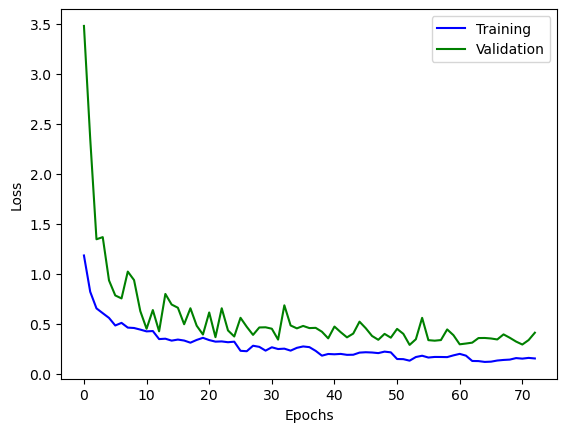

In [39]:
plot_history(history_quant_v2)

In [37]:
q_aware_model_v2.evaluate(x_test, y_test)

313/313 [==============================] - 67s 214ms/step - loss: 0.3100 - accuracy: 0.8969


[0.31004419922828674, 0.8968999981880188]

Nous obtenons alors une précision sur le dataset de test proche de celle obtenue avec le premier entrainement en _full float_. De même que pour le "fine tuning", la différence à espérer devrait être principalement visible entre pour une quantification en int8, entre un modèle avec QAT ou uniquement conversion PTQ.

In [38]:
q_aware_model_v2.save_weights("cifar10_mobilenet_qat_cold_897.h5")

### Conversition en modèle TensorFlow Lite

En utilisant le convertisseur de TensorFlow Lite, [Converter](https://www.tensorflow.org/lite/models/convert), il est facilement possible de convertir le modèle entraîné en modèle TensorFlow Lite.

Chargeons maintenant le modèle en utilisant `TFLiteConverter`:

In [55]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpjz2614em/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpjz2614em/assets
2023-06-07 11:00:37.666826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 11:00:37.666841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Nous pouvons maintenant enregistrer ce modèle de base.

In [56]:
tflite_models_dir = pathlib.Path("/tmp/cifar10_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [57]:
tflite_model_file = tflite_models_dir/"cifar10_qat_float.tflite"
tflite_model_file.write_bytes(tflite_model)

12841548

Nous avons donc une taille d'environ 13 Mb.

### Quantification du modèle en Integer8

Pour quantifier les données variables (telles que les entrées/sorties du modèle et les intermédiaires entre les couches), vous devez fournir un [`RepresentativeDataset`](https://www.tensorflow.org/api_docs/python/tf/lite/RepresentativeDataset). Il s'agit d'une fonction génératrice qui fournit un ensemble de données d'entrée suffisamment important pour représenter des valeurs typiques. Elle permet au convertisseur d'estimer une plage dynamique pour toutes les données variables. (Il n'est pas nécessaire que l'ensemble de données soit unique par rapport à l'ensemble de données d'apprentissage ou d'évaluation).

Pour prendre en charge des entrées multiples, chaque point de données représentatif est une liste et les éléments de la liste sont transmis au modèle en fonction de leurs indices.

In [49]:
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [tf.cast(input_value, tf.float32)]

Définissons (comme dans d'autres notebooks), une fonction qui nous permet, de façon simple et modulaire, de quantifier les modèles post-entrainement.

In [44]:
from typing import Callable

In [96]:
def post_training_quantization(model: tf.keras.Model, q_type: str, 
                               representative_data_gen: Callable = None, 
                               io_type: str = "keep_default"):
    if not isinstance(model, tf.keras.Model):
        raise TypeError("'model' seem not to be a tf.keras.Model.")
    if not isinstance(q_type, str):
        raise TypeError("'q_type' seem not to be a string")
    if q_type not in ("int8", "float16", "dynamic"):
        raise ValueError("Unknown q_type inserted. 'q_type' should be 'int8', 'float16' or 'dynamic'.")
    if not isinstance(io_type, str):
        raise TypeError("'io_type' seem not to be a string")
    if io_type not in ("same", "keep_default"):
        raise TypeError("Unknown 'io_type' inserted. io_type should be 'same' or 'keep_default'.")
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    if q_type == "int8":
        if representative_data_gen is None:
            raise ValueError("""For full integer quantization, a representative dataset should be passed as the 
                             'representative_data_gen' argument. Got None.""")
        if not isinstance(representative_data_gen, Callable):
            raise TypeError("'representative_data_gen' needs to be a callable function (generator).")
            
        converter.representative_dataset = representative_data_gen
        print("Quantifying model : Full Integer8 quantization.")
        
        if io_type == 'same':
            converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
            # Set the input and output tensors to uint8 (APIs added in r2.3)
            converter.inference_input_type = tf.uint8
            converter.inference_output_type = tf.uint8
            print("IO Type : Integer8")
        else:
            print("IO Type : Keep default (float32).")
            
    elif q_type == "float16":
        converter.target_spec.supported_types = [tf.float16]
        print("Quantifying model : Float16 quantization.")
    else:
        print("Quantifying model : Dynamic quantization.")
        
    tflite_model_quant = converter.convert()
    return tflite_model_quant

Nous allons utiliser succéssivement cette fonction pour quantifier (et enregistrer) respectivement :
- le modèle de base en PTQ vers int8
- le modèle de base avec fine tuning en QAT vers int8
- le modèle entrainé en QAT vers int8

In [105]:
tflite_model_quant = post_training_quantization(model, q_type="int8", 
                                                representative_data_gen=representative_data_gen,
                                                io_type="same")
tflite_model_quant_file = tflite_models_dir/"cifar10_qat_int.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

Quantifying model : Full Integer8 quantization.
IO Type : Integer8


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpa_4kem_w/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpa_4kem_w/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 18:15:29.027686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 18:15:29.027707: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


3521184

In [58]:
tflite_model_quant_warm = post_training_quantization(q_aware_model, q_type="int8", 
                                                    representative_data_gen=representative_data_gen,
                                                    io_type="same")
tflite_model_quant_warm_file = tflite_models_dir/"cifar10_qat_int_warm.tflite"
tflite_model_quant_warm_file.write_bytes(tflite_model_quant_warm)

Quantifying model : Full Integer8 quantization.
IO Type : Integer8


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpzynu2w7n/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpzynu2w7n/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 11:01:29.621570: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 11:01:29.621588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


3523280

In [59]:
tflite_model_quant_cold = post_training_quantization(q_aware_model_v2,q_type="int8", 
                                                    representative_data_gen=representative_data_gen,
                                                    io_type="same")
tflite_model_quant_cold_file = tflite_models_dir/"cifar10_qat_int_cold.tflite"
tflite_model_quant_cold_file.write_bytes(tflite_model_quant_cold)

Quantifying model : Full Integer8 quantization.
IO Type : Integer8


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpuewkgx91/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpuewkgx91/assets
/Users/axel.de.labriffe/miniforge3/envs/tensorflow-v3/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-06-07 11:01:48.711349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 11:01:48.711364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


3523280

In [60]:
!ls -lh {tflite_models_dir}

total 70848
-rw-r--r--  1 axel.de.labriffe  wheel    12M  6 jui 15:44 cifar10_model.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  6 jui 15:44 cifar10_model_quant.tflite
-rw-r--r--  1 axel.de.labriffe  wheel    12M  7 jui 11:00 cifar10_qat_float.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 cifar10_qat_int_cold.tflite
-rw-r--r--  1 axel.de.labriffe  wheel   3,4M  7 jui 11:01 cifar10_qat_int_warm.tflite


Notons que les modèles quantifiés ne font environ que `1/4` de la taille du modèle originel.

## Comparaison des modèles TFLite

Nous allons lancer les modèles TensorFlow Lite en utilisant l'interpreteur Python de TensorFlow Lite
`Interpreter`.

### Test du modèle sur une image

Nous allons maintenant exécuter des inférences en utilisant TensorFlow Lite [`Interpreter`] (https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) pour comparer la précision des modèles.


Tout d'abord, nous avons besoin d'une fonction qui exécute l'inférence avec un modèle et des images donnés (ici nos images de test), puis renvoie les prédictions.

In [61]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
    global test_images

    # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_images[test_image_index]
        test_label = test_labels[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

Créons une autre fonction pour imprimer nos prédictions.

In [62]:
import matplotlib.pylab as plt

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index][0]), 
                                  predict=str(predictions[0])))
    plt.grid(False)

Puis faisons un test pour le modèle Float :

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


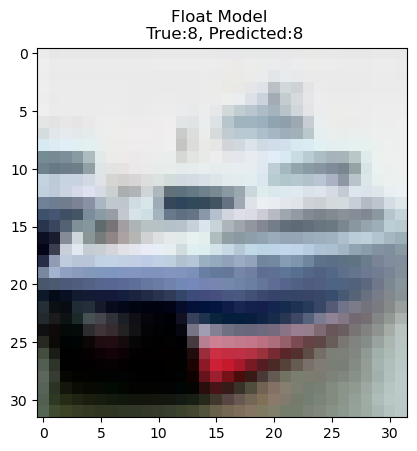

In [63]:
# Change this to test a different image
test_image_index = 1
test_model(tflite_model_file, test_image_index, model_type="Float")

Puis pour quelques modèles Quantifiés :

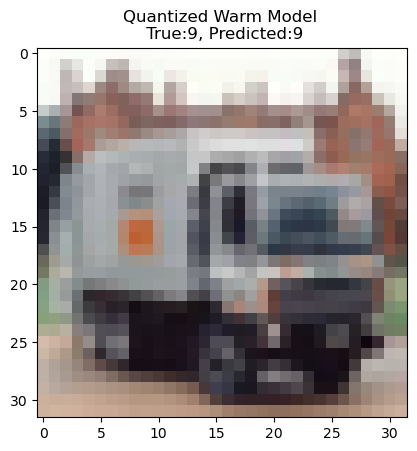

In [64]:
test_image_index = 11
test_model(tflite_model_quant_warm_file, test_image_index, model_type="Quantized Warm")

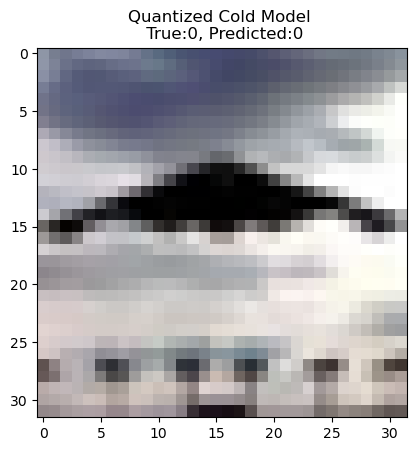

In [65]:
test_image_index = 111
test_model(tflite_model_quant_cold_file, test_image_index, model_type="Quantized Cold")

### Evaluation des modèles

Nous allons maintenant comparer les performances du modèle flottant et du modèle quantifié :

+ `tflite_model_file` est le modèle TensorFlow Lite original avec des données en virgule flottante.

+ `tflite_model_quant_file` est le modèle de base quantifié post-entrainement en uint8

+ `tflite_model_quant_warm_file` est le modèle que nous avons converti en utilisant la quantification des entiers seulement (il utilise des données uint8 pour l'entrée et la sortie), sachant que la première moitié de son entrainement a été fait de façon "classique" puis en QAT pour le "fine_tuning".

+ `tflite_model_quant_cold_file` est le dernier modèle que nous avons converti en utilisant la quantification des entiers seulement (il utilise des données uint8 pour l'entrée et la sortie), en faisant l'intégralité de son entrainement en QAT.

In [66]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
    global test_images
    global test_labels

    test_image_indices = range(test_images.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    accuracy = (np.sum(test_labels.flatten()==predictions) * 100) / len(test_images)

    print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Nous allons donc tester ces modèles sur le dataset de test, plusieurs fois pour obtenir un temps moyen.

__Modèle float de base__

In [67]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_file, model_type="Float")

Float model accuracy is 89.7500% (Number of test samples=10000)
Float model accuracy is 89.7500% (Number of test samples=10000)
Float model accuracy is 89.7500% (Number of test samples=10000)
2min 48s ± 492 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


__Modèle float quantifié post-entrainement en int8__

In [106]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_file, model_type="Quantized Int8 (PTQ)")

Quantized Int8 (PTQ) model accuracy is 86.8000% (Number of test samples=10000)
Quantized Int8 (PTQ) model accuracy is 86.8000% (Number of test samples=10000)
Quantized Int8 (PTQ) model accuracy is 86.8000% (Number of test samples=10000)
42 s ± 130 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


__Modèle float fine-tuné en QAT et quantifié en int8__

In [68]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_warm_file, model_type="Quantized Warm")

Quantized Warm model accuracy is 89.3400% (Number of test samples=10000)
Quantized Warm model accuracy is 89.3400% (Number of test samples=10000)
Quantized Warm model accuracy is 89.3400% (Number of test samples=10000)
42.8 s ± 160 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


__Modèle entrainé en QAT et quantifié en int8__

In [69]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_cold_file, model_type="Quantized Cold")

Quantized Cold model accuracy is 89.5200% (Number of test samples=10000)
Quantized Cold model accuracy is 89.5200% (Number of test samples=10000)
Quantized Cold model accuracy is 89.5200% (Number of test samples=10000)
43.1 s ± 74.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


On constate ici que le gain en temps d'inférence est conséquent, avec une division par 4 (environ).

### Quantification pour GPU (PTQ)

Pour avoir plus de comparaisons, nous allons aussi créer et évaluer un modèle quantifié en PTQ float16, qui est ainsi compatible GPU.

In [97]:
tflite_model_quant_f16 = post_training_quantization(model,q_type="float16", 
                                                    io_type="keep_default")
tflite_model_quant_f16_file = tflite_models_dir/"cifar10_qat_f16.tflite"
tflite_model_quant_f16_file.write_bytes(tflite_model_quant_f16)

Quantifying model : Float16 quantization.


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmp7qgqc_13/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmp7qgqc_13/assets
2023-06-07 12:40:21.960017: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 12:40:21.960044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


6436988

In [98]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_f16_file, model_type="Quantized Float 16 (PTQ)")

Quantized Float 16 model accuracy is 89.7600% (Number of test samples=10000)
Quantized Float 16 model accuracy is 89.7600% (Number of test samples=10000)
Quantized Float 16 model accuracy is 89.7600% (Number of test samples=10000)
2min 45s ± 292 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


On voit ainsi que la taille est divisée par 2 mais le temps d'inférence est le même (ou très proche). C'est dû au fait que les poids soient stockés en float16 mais que les opérations se font quand même en float32.

### Quantification Dynamique (PTQ) du modèle de base

Comparons également avec la quantification la plus simple, la quantification dynamique. Comme son nom l'indique, elle se fait dynamiquement au moment des inférences en convertissant les poids en int 8 et en faisant des calculs en mixant integer et float lorsque cela est possible (sinon uniquement en float).

Cependant, les outputs sont toujours stockés en float, ainsi l'augmentation de la vitesse en quantification dynamique est inférieure à celle d'une quantification statique (vers int8 par exemple).

In [101]:
tflite_model_quant_dyn = post_training_quantization(model, q_type="dynamic", 
                                                    io_type="keep_default")
tflite_model_quant_dyn_file = tflite_models_dir/"cifar10_qat_dyn.tflite"
tflite_model_quant_dyn_file.write_bytes(tflite_model_quant_dyn)

Quantifying model : Dynamic quantization.


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpu7of32f4/assets


INFO:tensorflow:Assets written to: /var/folders/s7/_kmb2q8x3zqbt58s_z98w_hh0000gn/T/tmpu7of32f4/assets
2023-06-07 16:59:30.181773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-07 16:59:30.181790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


3391224

In [102]:
%%timeit -r 3 -n 1
evaluate_model(tflite_model_quant_dyn_file, model_type="Quantized Dynamic (PTQ)")

Quantized Dynamic model accuracy is 89.4700% (Number of test samples=10000)
Quantized Dynamic model accuracy is 89.4700% (Number of test samples=10000)
Quantized Dynamic model accuracy is 89.4700% (Number of test samples=10000)
1min 5s ± 181 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


On voit ainsi de très bons résultats puisque la taille est divisée par 4, la précision du modèle est très bonne et l'inférence n'est pas aussi rapide qu'en statique mais les inférences sont nettement plus rapides.

### Evaluation Code Carbon

Nous allons maintenant faire une comparaison via la librairie Code Carbon qui permet d'estimer l'impact carbone d'un code en prenant en compte le CPU, la RAM etc.

Pour plus d'informations, visitez la [documentation officielle](https://mlco2.github.io/codecarbon/).

In [70]:
!pip install codecarbon

Nous allons utiliser _EmissionsTracker_ qui nous donnera des informations de consommations et les enregistrera aussi dans un fichier csv.

In [71]:
from codecarbon import EmissionsTracker

Puis comparons, pour une évaluation (donc 10000 inférences) la différence d'energie en kWh utilisé.
Commençons par le modèle classic Float.

__Modèle float de base__

In [72]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_file, model_type="Float")

[codecarbon INFO @ 11:23:50] [setup] RAM Tracking...
[codecarbon INFO @ 11:23:50] [setup] GPU Tracking...
[codecarbon INFO @ 11:23:50] No GPU found.
[codecarbon INFO @ 11:23:50] [setup] CPU Tracking...
[codecarbon WARNING @ 11:23:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:23:51] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 11:23:51] >>> Tracker's metadata:
[codecarbon INFO @ 11:23:51]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 11:23:51]   Python version: 3.9.16
[codecarbon INFO @ 11:23:51]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 11:23:51]   Available RAM : 32.000 GB
[codecarbon INFO @ 11:23:51]   CPU count: 10
[codecarbon INFO @ 11:23:51]   CPU model: Apple M1 Pro
[codecarbon INFO @ 11:23:51]   GPU count: None
[codecarbon INFO @ 11:23:51]   GPU model: None
[codecarbon INFO @ 11:24:09] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 11:24:09] Energy consume

Float model accuracy is 89.7500% (Number of test samples=10000)


Puis les modèle Quantifiés.

__Modèle float quantifié post-entrainement en int8__

In [107]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_file, model_type="Quantized Int8 (PTQ)")

[codecarbon INFO @ 18:19:49] [setup] RAM Tracking...
[codecarbon INFO @ 18:19:49] [setup] GPU Tracking...
[codecarbon INFO @ 18:19:49] No GPU found.
[codecarbon INFO @ 18:19:49] [setup] CPU Tracking...
[codecarbon WARNING @ 18:19:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:19:50] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 18:19:50] >>> Tracker's metadata:
[codecarbon INFO @ 18:19:50]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 18:19:50]   Python version: 3.9.16
[codecarbon INFO @ 18:19:50]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 18:19:50]   Available RAM : 32.000 GB
[codecarbon INFO @ 18:19:50]   CPU count: 10
[codecarbon INFO @ 18:19:50]   CPU model: Apple M1 Pro
[codecarbon INFO @ 18:19:50]   GPU count: None
[codecarbon INFO @ 18:19:50]   GPU model: None
[codecarbon INFO @ 18:20:06] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 18:20:06] Energy consume

Quantized Int8 (PTQ) model accuracy is 86.8000% (Number of test samples=10000)


__Modèle float fine-tuné en QAT et quantifié en int8__

In [73]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_warm_file, model_type="Quantized Warm")

[codecarbon INFO @ 11:26:41] [setup] RAM Tracking...
[codecarbon INFO @ 11:26:41] [setup] GPU Tracking...
[codecarbon INFO @ 11:26:41] No GPU found.
[codecarbon INFO @ 11:26:41] [setup] CPU Tracking...
[codecarbon WARNING @ 11:26:41] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:26:41] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 11:26:41] >>> Tracker's metadata:
[codecarbon INFO @ 11:26:41]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 11:26:41]   Python version: 3.9.16
[codecarbon INFO @ 11:26:41]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 11:26:41]   Available RAM : 32.000 GB
[codecarbon INFO @ 11:26:41]   CPU count: 10
[codecarbon INFO @ 11:26:41]   CPU model: Apple M1 Pro
[codecarbon INFO @ 11:26:41]   GPU count: None
[codecarbon INFO @ 11:26:41]   GPU model: None
[codecarbon INFO @ 11:26:57] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 11:26:57] Energy consume

Quantized model accuracy is 89.3400% (Number of test samples=10000)


__Modèle entrainé en QAT et quantifié en int8__

In [74]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_cold_file, model_type="Quantized Cold")

[codecarbon INFO @ 11:27:24] [setup] RAM Tracking...
[codecarbon INFO @ 11:27:24] [setup] GPU Tracking...
[codecarbon INFO @ 11:27:24] No GPU found.
[codecarbon INFO @ 11:27:24] [setup] CPU Tracking...
[codecarbon WARNING @ 11:27:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:27:24] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 11:27:24] >>> Tracker's metadata:
[codecarbon INFO @ 11:27:24]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 11:27:24]   Python version: 3.9.16
[codecarbon INFO @ 11:27:24]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 11:27:24]   Available RAM : 32.000 GB
[codecarbon INFO @ 11:27:24]   CPU count: 10
[codecarbon INFO @ 11:27:24]   CPU model: Apple M1 Pro
[codecarbon INFO @ 11:27:24]   GPU count: None
[codecarbon INFO @ 11:27:24]   GPU model: None
[codecarbon INFO @ 11:27:42] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 11:27:42] Energy consume

Quantized Cold model accuracy is 89.5200% (Number of test samples=10000)


On voit ainsi que l'énergie consommé est environ 4 fois inférieure pour les modèles ayant utilisé le QAT ! Et ce avec une précision très proche du modèle float.

__Modèle float quantifié post-entrainement en float16__

In [100]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_f16_file, model_type="Quantized Float16")

[codecarbon INFO @ 12:48:40] [setup] RAM Tracking...
[codecarbon INFO @ 12:48:40] [setup] GPU Tracking...
[codecarbon INFO @ 12:48:40] No GPU found.
[codecarbon INFO @ 12:48:40] [setup] CPU Tracking...
[codecarbon WARNING @ 12:48:40] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:48:40] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 12:48:40] >>> Tracker's metadata:
[codecarbon INFO @ 12:48:40]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 12:48:40]   Python version: 3.9.16
[codecarbon INFO @ 12:48:40]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 12:48:40]   Available RAM : 32.000 GB
[codecarbon INFO @ 12:48:40]   CPU count: 10
[codecarbon INFO @ 12:48:40]   CPU model: Apple M1 Pro
[codecarbon INFO @ 12:48:40]   GPU count: None
[codecarbon INFO @ 12:48:40]   GPU model: None
[codecarbon INFO @ 12:48:56] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 12:48:56] Energy consume

Quantized Float16 model accuracy is 89.7600% (Number of test samples=10000)


__Modèle float quantifié post-entrainement en dynamique__

In [103]:
with EmissionsTracker() as tracker:
    evaluate_model(tflite_model_quant_dyn_file, model_type="Quantized Dynamic")

[codecarbon INFO @ 17:02:46] [setup] RAM Tracking...
[codecarbon INFO @ 17:02:46] [setup] GPU Tracking...
[codecarbon INFO @ 17:02:46] No GPU found.
[codecarbon INFO @ 17:02:46] [setup] CPU Tracking...
[codecarbon WARNING @ 17:02:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:02:46] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon INFO @ 17:02:46] >>> Tracker's metadata:
[codecarbon INFO @ 17:02:46]   Platform system: macOS-13.4-arm64-arm-64bit
[codecarbon INFO @ 17:02:46]   Python version: 3.9.16
[codecarbon INFO @ 17:02:46]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 17:02:46]   Available RAM : 32.000 GB
[codecarbon INFO @ 17:02:46]   CPU count: 10
[codecarbon INFO @ 17:02:46]   CPU model: Apple M1 Pro
[codecarbon INFO @ 17:02:46]   GPU count: None
[codecarbon INFO @ 17:02:46]   GPU model: None
[codecarbon INFO @ 17:03:05] Energy consumed for RAM : 0.000050 kWh. RAM Power : 12.0 W
[codecarbon INFO @ 17:03:05] Energy consume

Quantized Dynamic model accuracy is 89.4700% (Number of test samples=10000)
